In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
sp500_futures = pd.read_csv("../data/sp500_futures_tick_data.csv")
sp500_futures.head()

,date,time,price,volume
0,01/03/2000,08:30:34.000,1496.4,0
1,01/03/2000,08:30:36.000,1496.0,0
2,01/03/2000,08:30:37.000,1495.5,0
3,01/03/2000,08:30:46.000,1495.0,0
4,01/03/2000,08:30:53.000,1495.5,0


In [3]:
sp500_futures['datetime'] = pd.to_datetime(sp500_futures.date + ' ' + sp500_futures.time)
sp500_futures.head()

,date,time,price,volume,datetime
0,01/03/2000,08:30:34.000,1496.4,0,2000-01-03 08:30:34
1,01/03/2000,08:30:36.000,1496.0,0,2000-01-03 08:30:36
2,01/03/2000,08:30:37.000,1495.5,0,2000-01-03 08:30:37
3,01/03/2000,08:30:46.000,1495.0,0,2000-01-03 08:30:46
4,01/03/2000,08:30:53.000,1495.5,0,2000-01-03 08:30:53


In [4]:
sp500_futures['dollar'] = sp500_futures.price * sp500_futures.volume

## 0. Add SP500 spot price

Join the price of sp500 to sp500_futures with matching date

In [5]:
# THE JOINING CODE HAS NOT BEEN TESTED SINCE THE LAST CHANGE
joining_sp500 = False
if joining_sp500:
    sp500_original = pd.read_csv('../data/sp500.csv')
    # The time is always "00:00:00"
    sp500 = pd.DataFrame()
    # Remove the time, which is always 00:00:00
    sp500['date'] = sp500_original.Date.str.replace("00:00:00", "").str.strip()
    # Change date format to match with dates from sp500_futures
    sp500['date'] = pd.to_datetime(sp500['date']).dt.strftime('%m/%d/%Y')
    # Set the price using the adjusted close
    sp500['price'] = sp500_original['Adj Close']
    
    del sp500_original

    print("sp500.head()")
    print(sp500.head())

    sp500_futures = pd.merge(sp500_futures, sp500, on='date') # inner join by default
    sp500_futures.rename(columns={'price_x': 'price', 'price_y': 'spot_price'}, inplace=True)
    
    print("sp500_futures.head()")
    print(sp500_futures.head())

## 1. Standard bars

### Convert time bars to tick bars

Note: Pick timestamp when the information was fully available to avoid look-ahead effects.

This means we could pick the last timestamp as the timestamp for the bar.

Get the bars for every tick count: date, time, bar_count, open, close, high, low, total_volume, complete

1. Is there any pre-hour and post-hour trading activities?
Yes, find the min and max of column 'time'

2. How to handle incomplete tick bars?
Answer: Keep the count of time bars, and add a column named 'complete' to mark if the tick bar is complete or not

3. Should I cutoff tick bars for each day? How to handle overnight trading?
Answer: For now, let's consider each day from 00:00 to 23:59 as a whole trading day

In [6]:
tick_size = 1000
sp500_futures['tick_group'] = sp500_futures.index // tick_size

In [7]:
def aggregate_bars(x):
    d = {}
    d['datetime'] = x['datetime'].iloc[-1] # The datetime of the last transaction
    d['open'] = x['price'].iloc[0] # The open price is the price of the first transaction
    d['close'] = x['price'].iloc[-1] # The close price is the price of the last transaction
    d['low'] = x['price'].min() 
    d['high'] = x['price'].max()
    d['total_volume'] = x['volume'].sum()
    # In edge case, d['total_volume'] can be 0 if all volume in the df is 0
    d['vol_weighted_avg_price'] = x['price'].dot(x['volume']) / d['total_volume'] if d['total_volume'] > 0 else 0
    d['dollar'] = x['dollar'].sum()
    d['count'] = x.shape[0]
    return pd.Series(d)

In [8]:
sp500_futures_ticks = sp500_futures.groupby('tick_group', as_index=False).apply(aggregate_bars)
sp500_futures_ticks.head()

,tick_group,datetime,open,close,low,high,total_volume,vol_weighted_avg_price,dollar,count
0,0,2000-01-03 10:02:42,1496.4,1457.0,1457.0,1496.4,0,0.0,0.0,1000
1,1,2000-01-03 11:38:49,1457.5,1457.5,1452.0,1462.5,0,0.0,0.0,1000
2,2,2000-01-03 13:14:11,1457.7,1461.2,1455.6,1465.0,0,0.0,0.0,1000
3,3,2000-01-03 14:42:12,1461.0,1466.5,1456.5,1467.0,0,0.0,0.0,1000
4,4,2000-01-04 09:29:12,1466.8,1449.0,1446.5,1469.5,0,0.0,0.0,1000


datetime
2000-01-09    20
2000-01-16    21
2000-01-23    17
2000-01-30    21
2000-02-06    19
Freq: W-SUN, dtype: int64

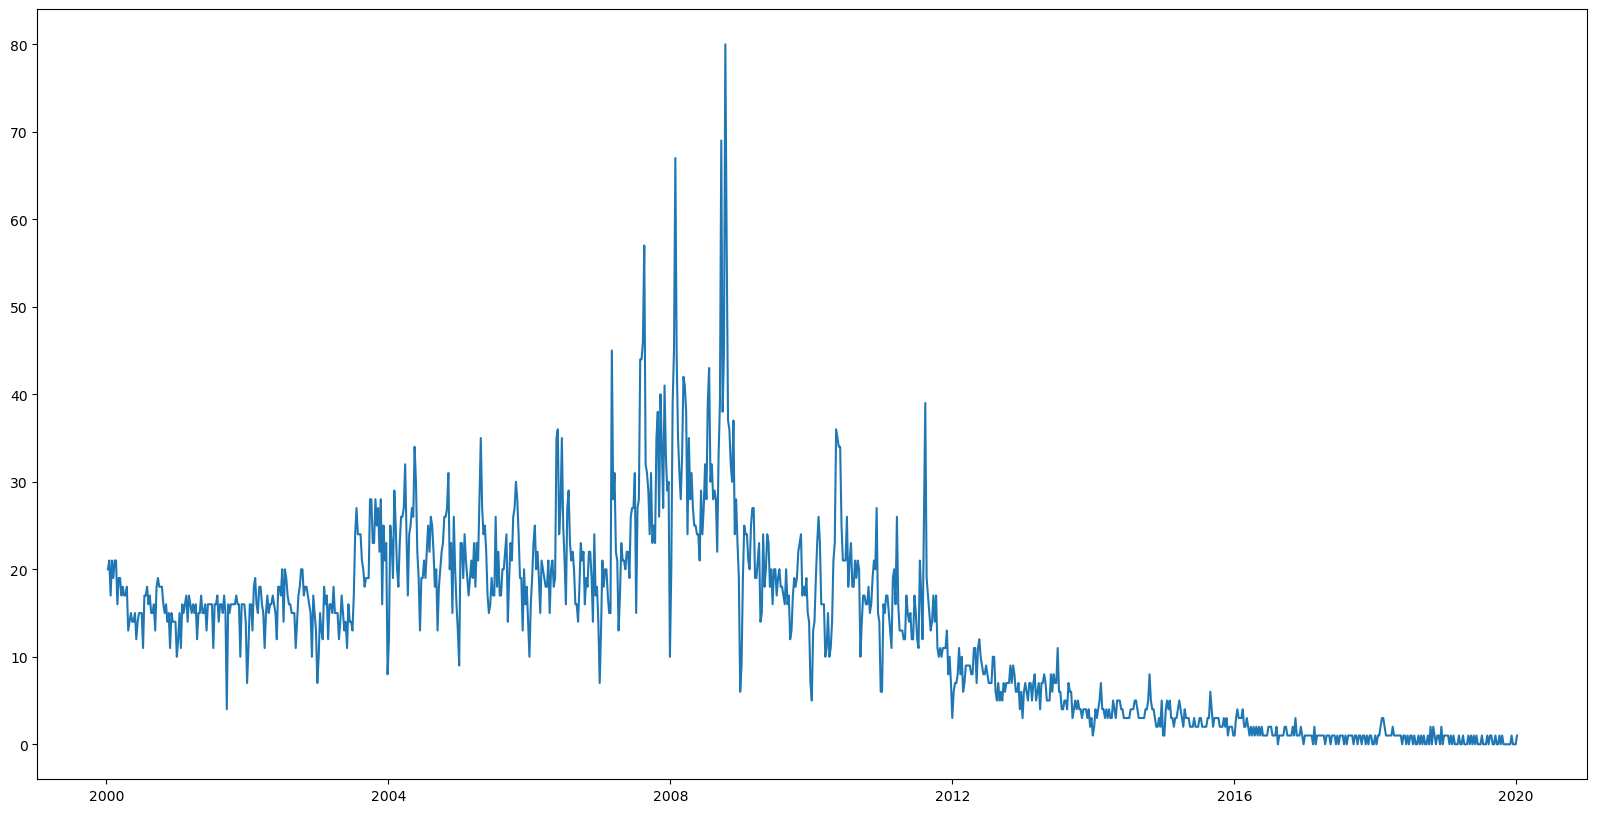

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
sp500_futures_ticks_agg = sp500_futures_ticks.resample(rule='W', on='datetime').size()
ax.plot(sp500_futures_ticks_agg)
sp500_futures_ticks_agg.head()

### Convert time bars to volume bars

In [10]:
volume_size = 1000
sp500_futures['volume_group'] = sp500_futures.volume.cumsum() // volume_size

In [11]:
sp500_futures_volumes = sp500_futures.groupby('volume_group', as_index=False).apply(aggregate_bars)
sp500_futures_volumes.head()

,volume_group,datetime,open,close,low,high,total_volume,vol_weighted_avg_price,dollar,count
0,0,2003-07-01 03:13:12,1496.4,971.8,767.5,1574.0,997,973.188365,970268.8,2813357
1,1,2003-07-01 06:27:39,971.9,971.1,971.1,973.2,999,972.021121,971049.1,524
2,2,2003-07-01 07:43:08,971.3,968.3,967.6,972.0,1003,970.340678,973251.7,451
3,3,2003-07-01 15:56:37,968.0,981.6,960.5,982.4,1000,969.736700,969736.7,3448
4,4,2003-07-02 01:26:16,981.7,982.5,981.3,984.0,999,982.660761,981678.1,416


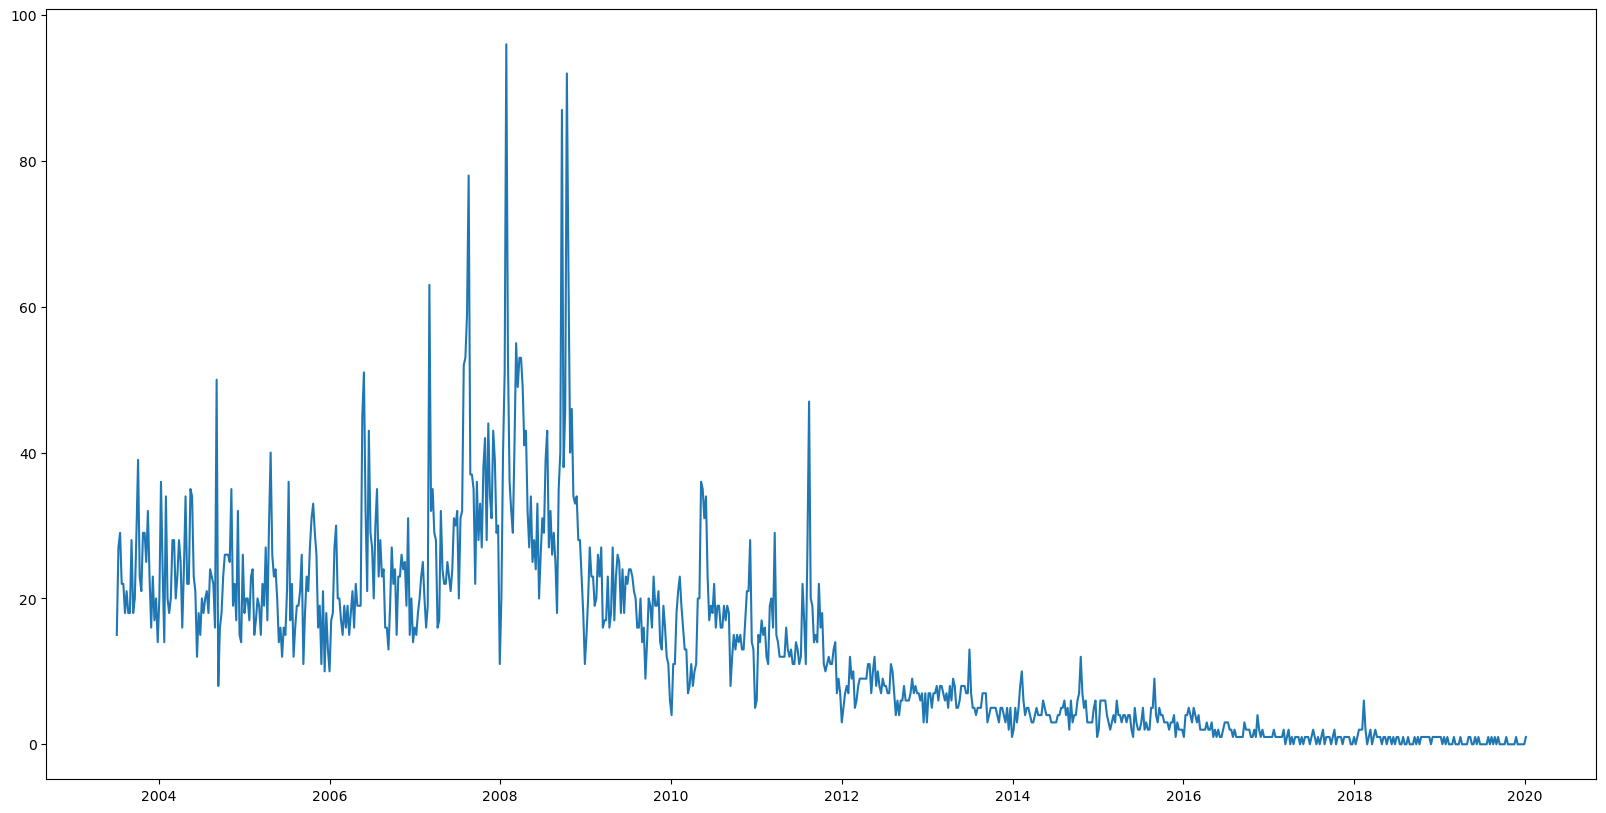

In [12]:
sp500_futures_volumes_agg = sp500_futures_volumes.resample(on='datetime', rule='W').size()
sp500_futures_volumes_agg.head()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sp500_futures_volumes_agg)

### Convert time bars to dollar bars

In [13]:
dollar_size = 1000000
sp500_futures['dollar'] = sp500_futures.price * sp500_futures.volume
sp500_futures['dollar_group'] = sp500_futures['dollar'].cumsum().astype(int) // dollar_size
sp500_futures.head()

,date,time,price,volume,datetime,dollar,tick_group,volume_group,dollar_group
0,01/03/2000,08:30:34.000,1496.4,0,2000-01-03 08:30:34,0.0,0,0,0
1,01/03/2000,08:30:36.000,1496.0,0,2000-01-03 08:30:36,0.0,0,0,0
2,01/03/2000,08:30:37.000,1495.5,0,2000-01-03 08:30:37,0.0,0,0,0
3,01/03/2000,08:30:46.000,1495.0,0,2000-01-03 08:30:46,0.0,0,0,0
4,01/03/2000,08:30:53.000,1495.5,0,2000-01-03 08:30:53,0.0,0,0,0


In [14]:
sp500_futures_dollar = sp500_futures.groupby('dollar_group', as_index=False).apply(aggregate_bars)
sp500_futures_dollar.head()

,dollar_group,datetime,open,close,low,high,total_volume,vol_weighted_avg_price,dollar,count
0,0,2003-07-01 03:16:30,1496.4,971.8,767.5,1574.0,1027,973.153262,999428.4,2813371
1,1,2003-07-01 06:32:03,971.9,971.3,971.1,973.2,1029,971.973761,1000161.0,532
2,2,2003-07-01 07:44:30,971.3,968.2,967.6,972.0,1021,970.135260,990508.1,468
3,3,2003-07-01 16:22:22,968.1,982.4,960.5,982.4,1039,971.218479,1009096.0,3447
4,4,2003-07-02 01:51:04,982.2,983.1,981.3,984.0,1017,982.785251,999492.6,428


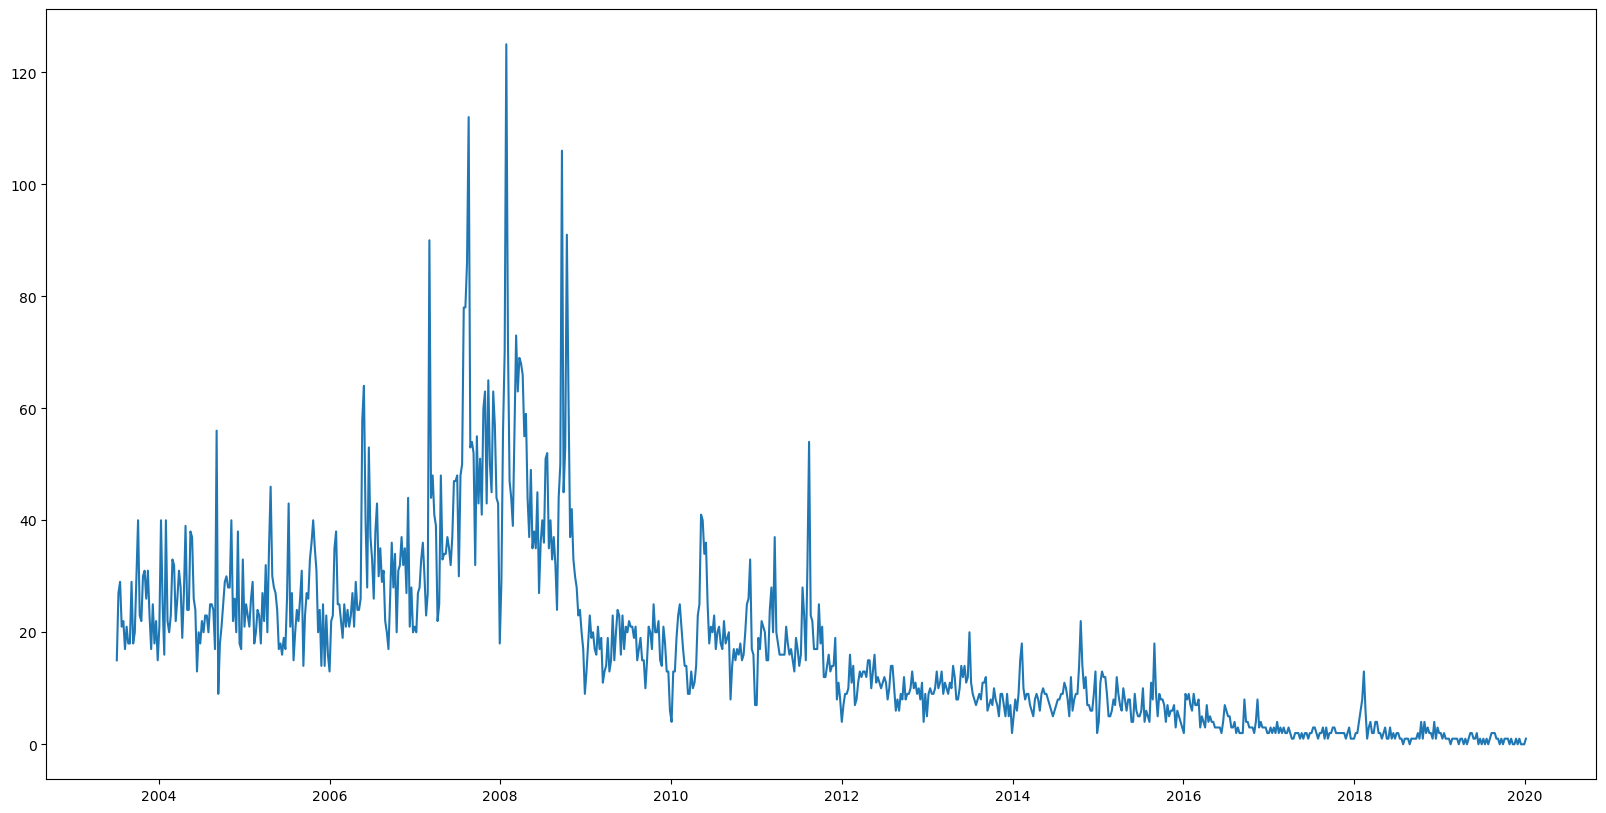

In [15]:
sp500_futures_dollar_agg = sp500_futures_dollar.resample(on='datetime', rule='W').size()
sp500_futures_dollar_agg.head()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sp500_futures_dollar_agg)

## 2. Information-driven bars

### Tick Imbalance Bars

In [ ]:
sp500_futures_tmp = sp500_futures.copy()
sp500_futures_tmp['bt'] = np.sign(sp500_futures_tmp.price.diff())
print(sp500_futures_tmp.shape)
sp500_futures_tmp.dropna(inplace=True)

In [ ]:
for idx, row in sp500_futures_tmp.iterrows():
    if row.bt == 0:
        sp500_futures_tmp.at[idx, 'bt'] = sp500_futures_tmp.at[idx-1, 'bt']

In [ ]:
exp_imb_size = [np.mean(sp500_futures_tmp.resample(on='datetime', rule='D').size())]
exp_buy_signal = [np.sum(sp500_futures_tmp.bt > 0) / sp500_futures_tmp.shape[0]]

In [ ]:
sp500_futures_tmp['tick_imb'] = False
cum_signal = 0
imb_size = 0
buy_bt = 0
for idx, row in sp500_futures_tmp.iterrows():
    if idx%200 == 0:
        print(idx)
    cum_signal += row.bt
    imb_size += 1
    
    if row.bt > 0:
        buy_bt += 1
    
    if np.abs(cum_signal) > np.mean(exp_imb_size) * (2*np.mean(exp_buy_signal) - 1):
        sp500_futures_tmp.at[idx, 'tick_imb'] = True
        exp_imb_size.append(imb_size)
        exp_buy_signal.append(buy_bt / imb_size)
        
        cum_signal = 0
        imb_size = 0
        buy_bt = 0

sp500_futures_tmp['tick_imb_group'] = sp500_futures_tmp['tick_imb'].cumsum()

In [ ]:
sp500_futures_tick_imb_agg = sp500_futures_tmp.groupby('tick_imb_group', as_index=False).apply(aggregate_bars)

### Volume Imbalance Bars

In [ ]:
exp_imb_size = [np.mean(sp500_futures_tmp.resample(on='datetime', rule='D').size())]
exp_buy_signal = [np.sum(sp500_futures_tmp.bt > 0) / sp500_futures_tmp.shape[0]]
exp_sell_signal = [1 - exp_buy_signal[0]]


exp_vol_buy = [sp500_futures_tmp[sp500_futures_tmp.bt == 1].volume.mean()]
exp_vol_sell = [sp500_futures_tmp[sp500_futures_tmp.bt == -1].volume.mean()]

In [ ]:
sp500_futures_tmp['vol_imb'] = False

cum_vol_imb = 0 # phi_T
imb_size = 0 # T
buy_bt = 0 # bt

vol_buy = []
vol_sell = []

for idx, row in sp500_futures_tmp.iterrows():
    cum_vol_imb += row.volume * row.bt
    imb_size += 1 # T
    
    if row.bt > 0:
        buy_bt += 1
        vol_buy.append(row.volume)
    else:
        vol_sell.append(row.volume)
    
    if np.abs(cum_vol_imb) > np.mean(exp_imb_size) * (np.dot(exp_buy_signal, exp_vol_buy) - np.dot(exp_sell_signal, exp_vol_sell)):
        sp500_futures_tmp.at[idx, 'vol_imb'] = True

        exp_imb_size.append(imb_size) # T

        exp_buy_signal.append(buy_bt / imb_size)
        exp_sell_signal.append(1 - buy_bt/imb_size)
        
        exp_vol_buy.append(np.mean(vol_buy))
        exp_vol_sell.append(np.mean(vol_sell))
        
        cum_vol_imb = 0
        imb_size = 0
        buy_bt = 0
        vol_buy = []
        vol_sell = []
        
sp500_futures_tmp['vol_imb_group'] = sp500_futures_tmp['vol_imb'].cumsum()

In [ ]:
sp500_futures_vol_imb_agg = sp500_futures_tmp.groupby('vol_imb_group', as_index=False).apply(aggregate_bars)

### Tick Runs Bars

In [ ]:
exp_imb_size = [sp500_futures_tmp.resample(on='datetime', rule='D').size().mean()]
exp_buy_prob = [np.sum(sp500_futures_tmp.bt == 1) / sp500_futures_tmp.shape[0]]

In [ ]:
sp500_futures_tmp['tick_run_imb'] = False
cur_imb_size = 0
buy_bt = 0
sell_bt = 0

for idx, row in sp500_futures_tmp.iterrows():
    cur_imb_size += 1
    if row.bt > 0:
        buy_bt += 1
    elif row.bt < 0:
        sell_bt += 1
    
    
    imb_val = np.max([buy_bt, sell_bt])
    if imb_val > np.mean(exp_imb_size) * np.max([np.mean(exp_buy_prob), 1-np.mean(exp_buy_prob)]):
        sp500_futures_tmp.at[idx, 'tick_run_imb'] = True

        exp_imb_size.append(cur_imb_size)
        exp_buy_prob.append(buy_bt / cur_imb_size)
        
        cur_imb_size = 0
        buy_bt = 0
        sell_bt = 0
    

sp500_futures_tmp['tick_run_imb_group'] = sp500_futures_tmp['tick_run_imb'].cumsum()

In [ ]:
sp500_futures_tick_run_imb_agg = sp500_futures_tmp.groupby('tick_run_imb_group', as_index=False).apply(aggregate_bars)

## 3. ETF Rolling (TODO later)

## 4. Compute serial correlation for each type of ticks data

In [16]:
# sp500_futures_ticks.head()
sp500_futures_ticks[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.999296
close                     0.999293
high                      0.999514
total_volume              0.343566
vol_weighted_avg_price    0.638128
dtype: float64

In [17]:
# sp500_futures_volumes.head()
sp500_futures_volumes[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.999214
close                     0.999363
high                      0.999231
total_volume              0.142834
vol_weighted_avg_price    0.999573
dtype: float64

In [18]:
sp500_futures_dollar[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.999507
close                     0.999598
high                      0.999529
total_volume              0.741864
vol_weighted_avg_price    0.999741
dtype: float64

## 5. Compute the variance of returns for each month, then the variance of variances for each tick type

In [20]:
sp500_futures_ticks['intraday_simple_return'] = (sp500_futures_ticks.close - sp500_futures_ticks.open) / sp500_futures_ticks.open * 100
sp500_futures_ticks['intraday_log_return'] = np.log(sp500_futures_ticks.close / sp500_futures_ticks.open)
sp500_futures_ticks.groupby(pd.Grouper(key='datetime', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    9.220297e+00
intraday_log_return       9.314725e-08
dtype: float64

In [21]:
sp500_futures_volumes['intraday_simple_return'] = (sp500_futures_volumes.close - sp500_futures_volumes.open) / sp500_futures_volumes.open * 100
sp500_futures_volumes['intraday_log_return'] = np.log(sp500_futures_volumes.close / sp500_futures_volumes.open)
sp500_futures_volumes.groupby(pd.Grouper(key='datetime', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    6.714683e+00
intraday_log_return       7.573487e-08
dtype: float64

In [22]:
sp500_futures_dollar['intraday_simple_return'] = (sp500_futures_dollar.close - sp500_futures_dollar.open) / sp500_futures_dollar.open * 100
sp500_futures_dollar['intraday_log_return'] = np.log(sp500_futures_dollar.close / sp500_futures_dollar.open)
sp500_futures_dollar.groupby(pd.Grouper(key='datetime', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    2.681835e+00
intraday_log_return       3.489074e-08
dtype: float64

In [23]:
# Reject the Normal hypothesis if pvalue < 0.05
print(stats.jarque_bera(sp500_futures_ticks['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_ticks['intraday_log_return']))

SignificanceResult(statistic=79257.66083400609, pvalue=0.0)
SignificanceResult(statistic=76376.3076591425, pvalue=0.0)


In [24]:
print(stats.jarque_bera(sp500_futures_volumes['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_volumes['intraday_log_return']))

SignificanceResult(statistic=97607764.01110171, pvalue=0.0)
SignificanceResult(statistic=336962683.6749098, pvalue=0.0)


In [25]:
# Reject the Normal hypothesis if pvalue < 0.05
print(stats.jarque_bera(sp500_futures_dollar['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_dollar['intraday_log_return']))

SignificanceResult(statistic=181407075.6035368, pvalue=0.0)
SignificanceResult(statistic=634045985.4982, pvalue=0.0)


## 6. Bollinger band

In [88]:
# Compute Bollinger band using 20-day Simple Moving Average
sp500_futures_dollar_bollinger = sp500_futures_dollar.resample(on='datetime', rule='M')[['high', 'low', 'close']].sum() 
sp500_futures_dollar_bollinger.reset_index(inplace=True)

bollinger_window = 20 # days
band_width = 5
sp500_futures_dollar_bollinger['typical_price'] = 1/3 * (sp500_futures_dollar_bollinger['high'] + sp500_futures_dollar_bollinger['low'] + sp500_futures_dollar_bollinger['close'])
sp500_futures_dollar_bollinger['bollinger'] = sp500_futures_dollar_bollinger.typical_price.rolling(bollinger_window).mean()
sp500_futures_dollar_bollinger[f'bollinger+{band_width}%'] = sp500_futures_dollar_bollinger['bollinger'] * (1+band_width/100)
sp500_futures_dollar_bollinger[f'bollinger-{band_width}%'] = sp500_futures_dollar_bollinger['bollinger'] * (1-band_width/100)

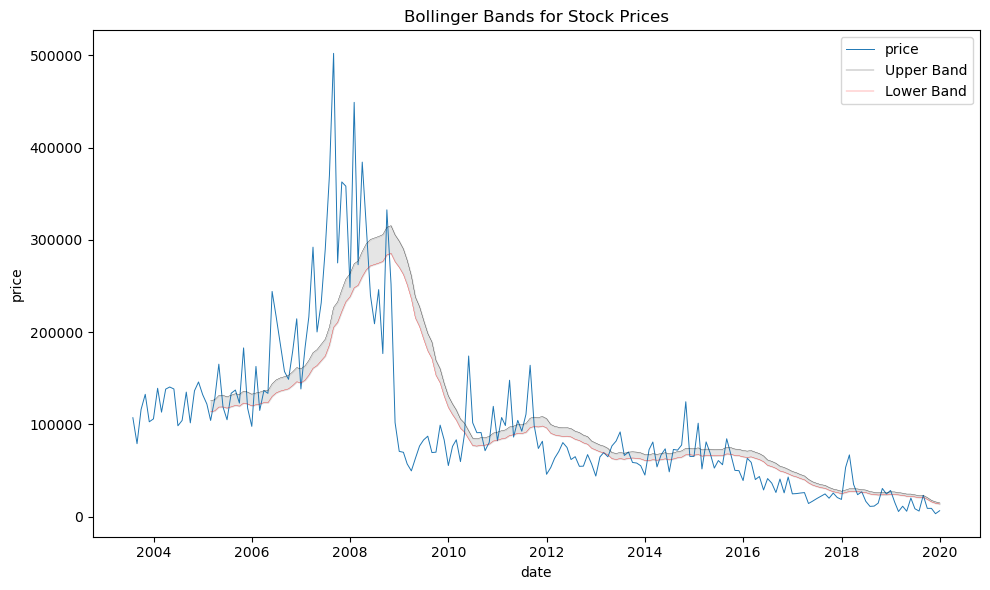

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the price data
ax.plot(sp500_futures_dollar_bollinger["datetime"], sp500_futures_dollar_bollinger["typical_price"], linewidth=0.7, label="price")

# Plot the Bollinger Bands
ax.plot(sp500_futures_dollar_bollinger["datetime"], sp500_futures_dollar_bollinger[f'bollinger+{band_width}%'], color='black', linewidth=0.2, label="Upper Band")
ax.plot(sp500_futures_dollar_bollinger["datetime"], sp500_futures_dollar_bollinger[f'bollinger-{band_width}%'], color='red', linewidth=0.2, label="Lower Band")
ax.fill_between(sp500_futures_dollar_bollinger["datetime"], sp500_futures_dollar_bollinger[f'bollinger-{band_width}%'], sp500_futures_dollar_bollinger[f'bollinger+{band_width}%'], alpha=0.2, color="gray")

# Add labels and title
ax.set_xlabel("date")
ax.set_ylabel("price")
ax.set_title("Bollinger Bands for Stock Prices")

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()
# sp500_futures_dollar[['date', 'typical_price', 'bollinger+5%', 'bollinger-5%']].plot(x='date')

## 7. CUSUM filter

Count the number of samples using a CUSUM filter, where {yt} are returns and h = 0.05

In [99]:
ema_window = 100
sp500_futures_dollar['prev_ema'] = sp500_futures_dollar['intraday_log_return'].ewm(span=ema_window).mean().shift()
sp500_futures_dollar['return_deviation'] = sp500_futures_dollar.intraday_log_return - sp500_futures_dollar.prev_ema
sp500_futures_dollar.dropna(axis=0, inplace=True, ignore_index=True)

In [102]:
# Use E_{t-1}(y_t) = EMA_{t-1}(y_t)
def cumsum_filter_pos(row, threshold=0.05):
    if row.name == 0:
        cumsum_filter_pos.cumsum = 0
        cumsum_filter_pos.count = 0
    
    cumsum_filter_pos.cumsum = max(0, cumsum_filter_pos.cumsum + row.return_deviation)
    if cumsum_filter_pos.cumsum > threshold:
        cumsum_filter_pos.cumsum = 0
        cumsum_filter_pos.count =+ 1
    
    return cumsum_filter_pos.cumsum, cumsum_filter_pos.count


def cumsum_filter_neg(row, threshold=0.05):
    if row.name == 0:
        cumsum_filter_neg.cumsum = 0
        cumsum_filter_neg.count = 0
    
    cumsum_filter_neg.cumsum = min(0, cumsum_filter_neg.cumsum + row.return_deviation)
    if cumsum_filter_neg.cumsum < -threshold:
        cumsum_filter_neg.cumsum = 0
        cumsum_filter_neg.count += 1
    
    return cumsum_filter_neg.cumsum, cumsum_filter_neg.count

In [103]:
sp500_futures_dollar['cusum_filter_pos'] = sp500_futures_dollar.apply(cumsum_filter_pos, axis=1)
sp500_futures_dollar['cusum_filter_neg'] = sp500_futures_dollar.apply(cumsum_filter_neg, axis=1)

In [105]:
sp500_futures_dollar[['cusum_filter_pos', 'cusum_filter_neg']].tail()

,cusum_filter_pos,cusum_filter_neg
14837,"(0.02405742322209789, 1)","(-0.01470560014886134, 114)"
14838,"(0.04567830163054432, 1)","(0, 114)"
14839,"(0, 1)","(0, 114)"
14840,"(0.0066224443931439435, 1)","(0, 114)"
14841,"(0.03410910784289278, 1)","(0, 114)"
